<a href="https://colab.research.google.com/github/dickylcd/Financial_Analysis/blob/main/Retire_Portfolio%20_Analysis-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install missing lib
#!pip install yfinance
#!pip install ffn

In [ ]:
#import Python Lib
import pandas as pd
import ffn 
import numpy as np
from pylab import mpl, plt
import scipy.stats as scs
import scipy.optimize as sco
from scipy.optimize import minimize
import time
import yfinance
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

**Normal retire portfolio will include CLP (0002.HK), Town Gas (0003.HK) and MTR (0066.HK), let's see the performance in past ten years**

In [ ]:
#Initial Portfolio

# Define the dates of data
start_date = '2011-01-01'
end_date = '2021-12-03'

#Portfolio
stock_symbols = ['0003.HK', '0066.HK', '0002.HK']

In [ ]:
#Get information for our portfolio
prices = yfinance.download(stock_symbols, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [ ]:
prices.head()

,0002.HK,0003.HK,0066.HK
Date,,,
2011-01-03,40.770016,5.623724,19.245419
2011-01-04,40.546902,5.635911,19.278545
2011-01-05,40.738155,5.629818,19.146048
2011-01-06,40.929401,5.550611,19.146048
2011-01-07,40.929401,5.550611,19.146048


In [ ]:
#Data Manipulation
clp = prices['0002.HK']
tgas = prices['0003.HK']
mtr = prices['0066.HK']

clp = clp.to_frame()
clp = clp.rename(columns={'Date':'Date', '0002.HK':'Adj Close'})

tgas = tgas.to_frame()
tgas = tgas.rename(columns={'Date':'Date', '0003.HK':'Adj Close'})

mtr = mtr.to_frame()
mtr = mtr.rename(columns={'Date':'Date', '0066.HK':'Adj Close'})

In [ ]:
#Normalize Prices
for stock_df in (clp, tgas, mtr):
  stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']


**Let limit the investment as 5 Million and the stock allocation CLP 40%, Town Gas 20% & MTR 40%**

In [ ]:
#Allocation
for stock_df, allo in zip([clp,tgas,mtr],[0.4,0.2,0.4]):
  stock_df['Allocation'] = stock_df['Normed Return'] * allo

In [ ]:
#Investment 5 Million
for stock_df in [clp,tgas,mtr]:
    stock_df['Position Values'] = stock_df['Allocation'] * 5000000

In [ ]:
#Total Portfolio Value
portfolio_value = pd.concat([clp['Position Values'], tgas['Position Values'], mtr['Position Values']], axis=1)

portfolio_value.columns = ['CLP Pos', 'TownGas Pos', 'MTR Pos']
portfolio_value['Total Pos'] = portfolio_value.sum(axis=1)
portfolio_value.head()

,CLP Pos,TownGas Pos,MTR Pos,Total Pos
Date,,,,
2011-01-03,2.000000e+06,1.000000e+06,2.000000e+06,5.000000e+06
2011-01-04,1.989055e+06,1.002167e+06,2.003443e+06,4.994665e+06
2011-01-05,1.998437e+06,1.001084e+06,1.989673e+06,4.989194e+06
2011-01-06,2.007819e+06,9.869991e+05,1.989673e+06,4.984491e+06
2011-01-07,2.007819e+06,9.869991e+05,1.989673e+06,4.984491e+06


Text(0.5, 1.0, 'Total Portfolio Value')

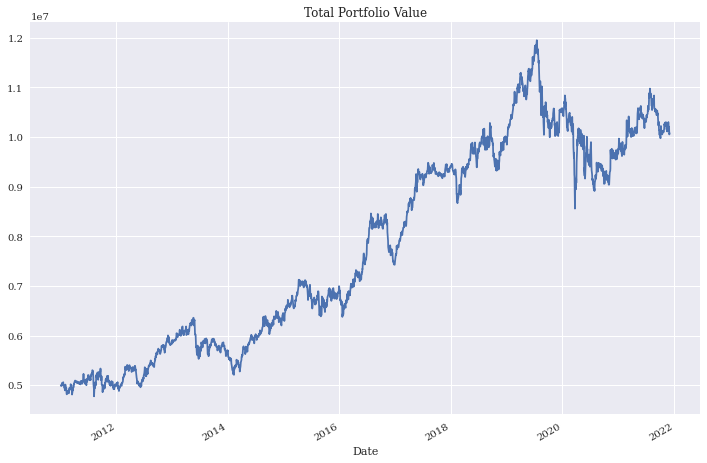

In [ ]:
#Plot Graph
portfolio_value['Total Pos'].plot(figsize = (12, 8))
plt.title('Total Portfolio Value')


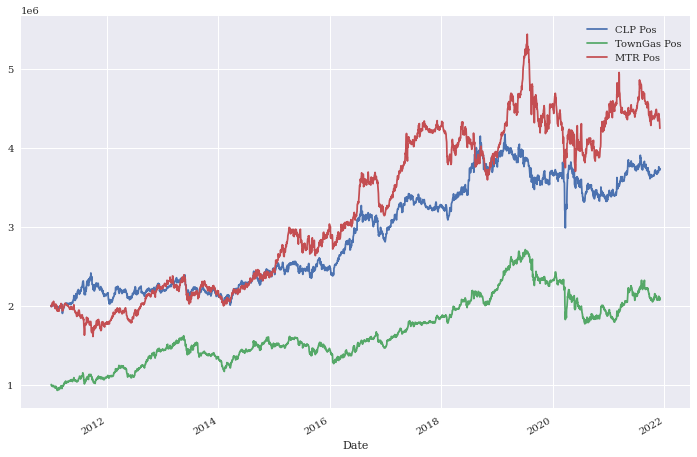

In [ ]:
portfolio_value.drop('Total Pos', axis=1).plot(kind='line', figsize = (12,8))

In [ ]:
#Daily Return
portfolio_value['Daily Return'] = portfolio_value['Total Pos'].pct_change(1)

In [ ]:
#Cumulative Return
cum_ret = 100 * (portfolio_value['Total Pos'][-1] / portfolio_value['Total Pos'][0] - 1 )
print(cum_ret)

101.58016697442456


In [ ]:
#Adv Daily Return
portfolio_value['Daily Return'].mean()

0.0002965071584927052

In [ ]:
#Std Daily Return
portfolio_value['Daily Return'].std()

0.008473730664218028

**Daily percentage change**

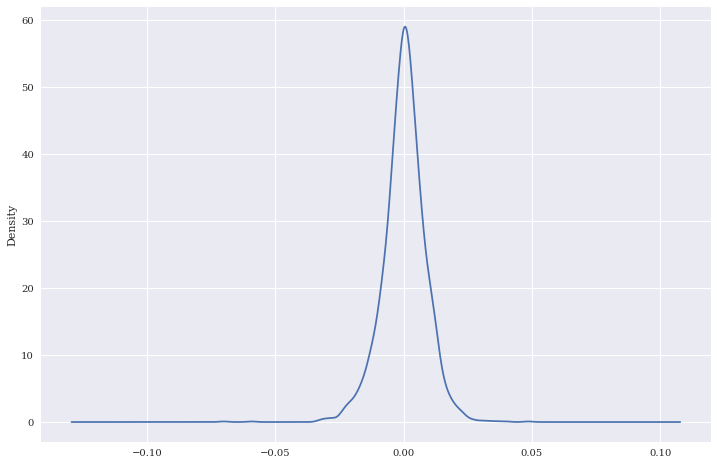

In [ ]:
fig = plt.figure(figsize=(12,8))
portfolio_value['Daily Return'].plot(kind = 'kde')

In [ ]:

clp_s = clp['Adj Close'].pct_change(1)
tgas_s = tgas['Adj Close'].pct_change(1)
mtr_s = mtr['Adj Close'].pct_change(1)

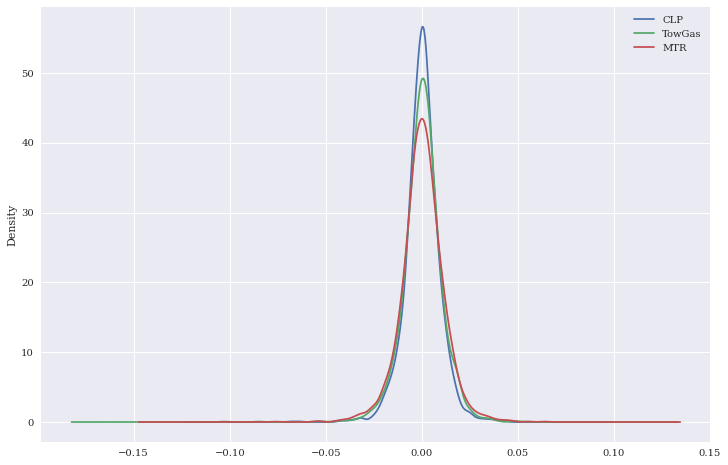

In [ ]:
fig = plt.figure(figsize=(12,8))

clp_s.plot(kind='kde', label='CLP')
tgas_s.plot(kind='kde', label='TowGas')
mtr_s.plot(kind='kde', label='MTR')

plt.legend()

**Sharpe Ratio Calculate**

In [ ]:
#@title
#Sharpe Ratio
sharpe_ratio = portfolio_value['Daily Return'].mean() / portfolio_value['Daily Return'].std()

#Annualized Sharpe Ratio
annualized_sharpe_ratio = (252 ** 0.5) * sharpe_ratio

print(sharpe_ratio)
print(annualized_sharpe_ratio)

0.03499133619443018
0.555470241673893


In [ ]:
#define function

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def min_func_sharpe(weights):
    return -port_ret(weights)/port_vol(weights)

In [ ]:
noa = len(stock_symbols)

#Calculate Daily Returns
rets = np.log(prices / prices.shift(1))

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
print('The return is: {:.2f}'.format(port_ret(opts['x'].round(3))))
print('the volatility is: {:.2f}'.format(port_vol(opts['x'].round(3))))
print("The Sharpe Ratio is: {:.2f}".format(port_ret(opts['x']/port_vol(opts['x']))))

The return is: 0.07
the volatility is: 0.13
The Sharpe Ratio is: 0.49


**Portfolio Optimization**

In [ ]:
#Defining Functions

#Risk defined as standard deviation
def get_risk(prices):
  return (prices / prices.shift(1) -1).dropna().std().values

def get_return(prices):
  return ((prices / prices.shift(1) -1).dropna().mean() * np.sqrt(250)).values

In [ ]:
#Drop all Nil value
prices = prices.dropna()

In [ ]:
#Value of Risk and Return
risk_value = get_risk(prices)
return_value = get_return(prices)

In [ ]:
prices

,0002.HK,0003.HK,0066.HK
Date,,,
2011-01-03,40.770016,5.623724,19.245419
2011-01-04,40.546902,5.635911,19.278545
2011-01-05,40.738155,5.629818,19.146048
2011-01-06,40.929401,5.550611,19.146048
2011-01-07,40.929401,5.550611,19.146048
...,...,...,...
2021-11-26,75.918350,11.800000,42.200001
2021-11-29,76.166290,11.840000,42.000000
2021-11-30,75.769585,11.640000,41.599998


In [ ]:
#Dail return
daily_returns = (prices / prices.shift(1) - 1).dropna()
daily_returns

,0002.HK,0003.HK,0066.HK
Date,,,
2011-01-04,-0.005473,0.002167,0.001721
2011-01-05,0.004717,-0.001081,-0.006873
2011-01-06,0.004695,-0.014069,0.000000
2011-01-07,0.000000,0.000000,0.000000
2011-01-10,-0.003115,-0.007684,0.012111
...,...,...,...
2021-11-26,-0.009061,-0.010067,-0.008226
2021-11-29,0.003266,0.003390,-0.004739
2021-11-30,-0.005208,-0.016892,-0.009524


In [ ]:
#Standard devision of the retruns
daily_returns.std()

0002.HK    0.009078
0003.HK    0.010299
0066.HK    0.011191
dtype: float64

In [ ]:
#Average of the rerutns
daily_returns.mean()

0002.HK    0.000273
0003.HK    0.000329
0066.HK    0.000342
dtype: float64

In [ ]:
#Annualize the return
daily_returns.mean() * np.sqrt(250)

0002.HK    0.004324
0003.HK    0.005197
0066.HK    0.005413
dtype: float64

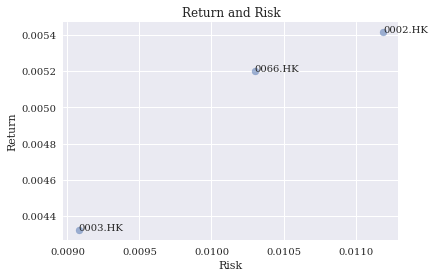

In [ ]:
#Plot return and risk value
fig, ax = plt.subplots()
ax.scatter(x=risk_value, y=return_value, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
for i, symbol in enumerate(stock_symbols):
  ax.annotate(symbol, (risk_value[i], return_value[i]))

plt.show()

**Build portfolio with random weight**

In [ ]:
#define function
def random_weights(n):
    weights = np.random.rand(n)
    return weights / sum(weights)

def get_portfolio_risk(weights, normalized_prices):
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    return (portfolio / portfolio.shift(1) - 1).dropna().std().values[0]

def get_portfolio_return(weights, normalized_prices):
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    ret = get_return(portfolio)
    return ret[0]

In [ ]:
#initial
risk_all = np.array([])
return_all = np.array([])

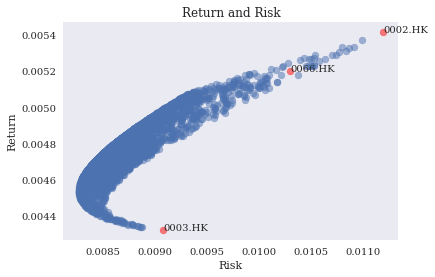

In [ ]:
#Plot 3000 random portfolio
np.random.seed(0)
normalized_prices = prices / prices.iloc[0, :]

for _ in range(0, 3000):
    weights = random_weights(len(stock_symbols))
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=prices.index, data={'portfolio': portfolio_val})
    risk = get_risk(portfolio)
    ret = get_return(portfolio)
    risk_all = np.append(risk_all, risk)
    return_all = np.append(return_all, ret)
    p = get_portfolio_risk(weights=weights, normalized_prices=normalized_prices)

#Plot graph    
fig, ax = plt.subplots()
ax.scatter(x=risk_all, y=return_all, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(stock_symbols):
    ax.annotate(symbol, (risk_value[i], return_value[i]))

ax.scatter(x=risk_value, y=return_value, alpha=0.5, color='red')
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
ax.grid()
plt.show()

**Efficient Frontier**

In [ ]:
#Optimizer function
def optimize(prices, symbols, target_return=0.1):
    normalized_prices = prices / prices.iloc[0, :]
    init_guess = np.ones(len(symbols)) * (1.0 / len(symbols))
    bounds = ((0.0, 1.0),) * len(symbols)
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(normalized_prices,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (normalized_prices,),
                                     'fun': lambda inputs, normalized_prices:
                                     target_return - get_portfolio_return(weights=inputs,
                                      normalized_prices=normalized_prices)}),
                                      bounds=bounds)
    return weights.x

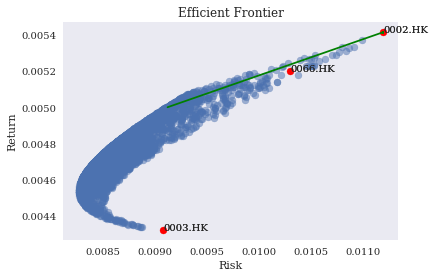

In [ ]:
optimal_risk_all = np.array([])
optimal_return_all = np.array([])
for target_return in np.arange(0.005, .0402, .0005):
    opt_w = optimize(prices=prices, symbols=stock_symbols, target_return=target_return)
    optimal_risk_all = np.append(optimal_risk_all, get_portfolio_risk(opt_w, normalized_prices))
    optimal_return_all = np.append(optimal_return_all, get_portfolio_return(opt_w, normalized_prices))

#Plot graph
fig, ax = plt.subplots()

#Random portfolio risk return
ax.scatter(x=risk_all, y=return_all, alpha=0.5)

#Optimal portfolio risk return
for i, symbol in enumerate(stock_symbols):
    ax.annotate(symbol, (risk_value[i], return_value[i]))
ax.plot(optimal_risk_all, optimal_return_all, '-', color='green')

# Stock Symbol risk and return
for i, symbol in enumerate(stock_symbols):
    ax.annotate(symbol, (risk_value[i], return_value[i]))

ax.scatter(x=risk_value, y=return_value, color='red')
ax.set(title='Efficient Frontier', xlabel='Risk', ylabel='Return')
ax.grid()
plt.savefig('return_risk_efficient_frontier.png', bbox_inches='tight')


